In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 检测特征点

In [2]:
def detect_sift_features(image):
    """
    使用SIFT特征检测器检测特征点和特征描述符
    """
    sift = cv2.SIFT_create()
    (kp,des) = sift.detectAndCompute(image, None)
    return (kp,des)

# 图像转换为灰度图

In [3]:
def convert_to_gray(image):
    """
    将图像转换为灰度图像
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [9]:
def match_features(kp1, des1, kp2, des2):
    """
    使用FLANN匹配器匹配特征点
    """
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches

In [5]:
def calculate_homography(src_pts, dst_pts):
    """
    计算单应性变换矩阵
    """
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

In [6]:
def warp_image(image, H):
    """
    对图像进行透视变换
    """
    return cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))


In [7]:
def compute_and_display_homography(image1, image2):
    """
    计算单应性变换矩阵并显示图像
    """
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Image 1')

    axs[0, 1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Image 2')

    gray1 = convert_to_gray(image1)
    gray2 = convert_to_gray(image2)

    axs[0, 2].imshow(gray1, cmap='gray')
    axs[0, 2].set_title('Gray Image 1')

    axs[1, 0].imshow(gray2, cmap='gray')
    axs[1, 0].set_title('Gray Image 2')

    kp1, des1 = detect_sift_features(gray1)
    kp2, des2 = detect_sift_features(gray2)

    img1_with_kp = cv2.drawKeypoints(image1, kp1, None, color=(0, 255, 0))
    axs[1, 1].imshow(cv2.cvtColor(img1_with_kp, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title('Image 1 with Keypoints')

    img2_with_kp = cv2.drawKeypoints(image2, kp2, None, color=(0, 255, 0))
    axs[1, 2].imshow(cv2.cvtColor(img2_with_kp, cv2.COLOR_BGR2RGB))
    axs[1, 2].set_title('Image 2 with Keypoints')

    plt.show()

    src_pts, dst_pts ,good_matches = match_features(kp1, des1, kp2, des2)

    H = calculate_homography(src_pts, dst_pts)
    print("H:")
    print(H)

    result = warp_image(image1, H)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Result')
    plt.show()

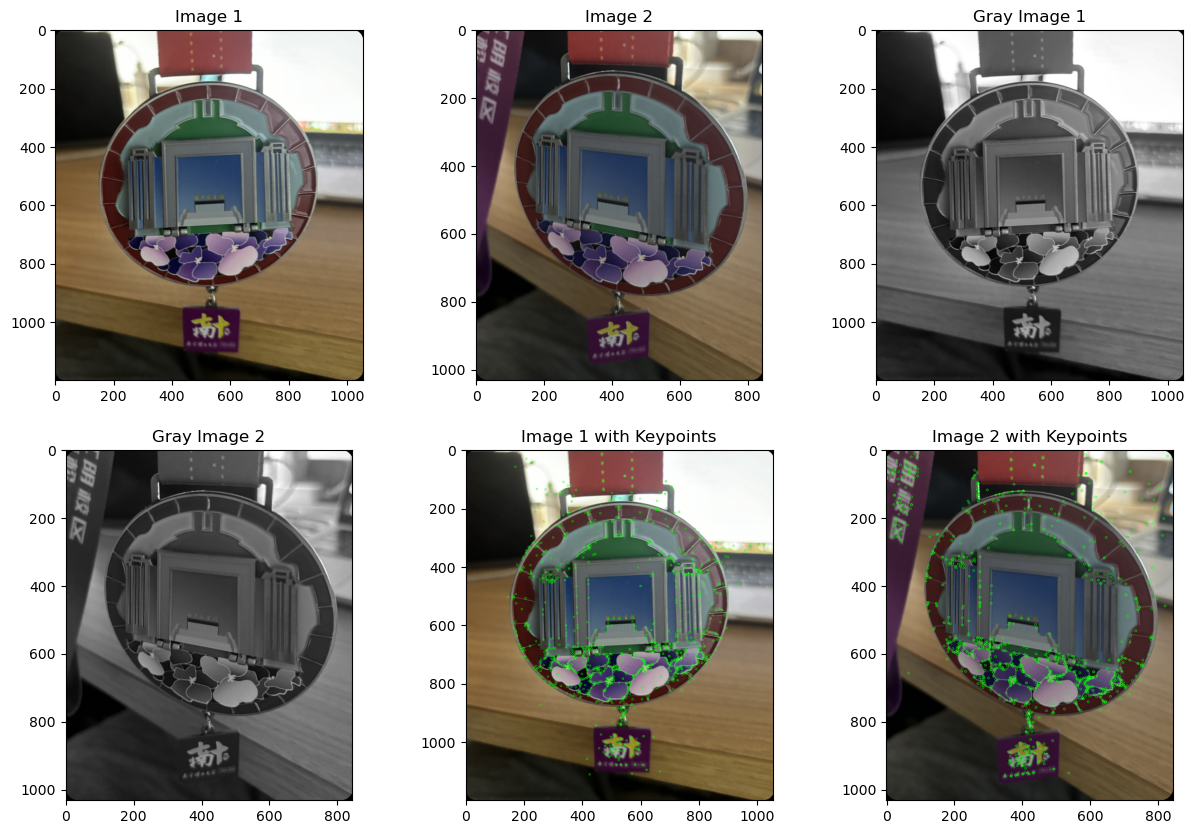

H:
[[ 6.21231685e-01 -2.32250571e-02  2.63884300e+01]
 [ 7.34732844e-03  7.43664549e-01 -2.04242792e+01]
 [-3.03771229e-04 -1.23383782e-05  1.00000000e+00]]


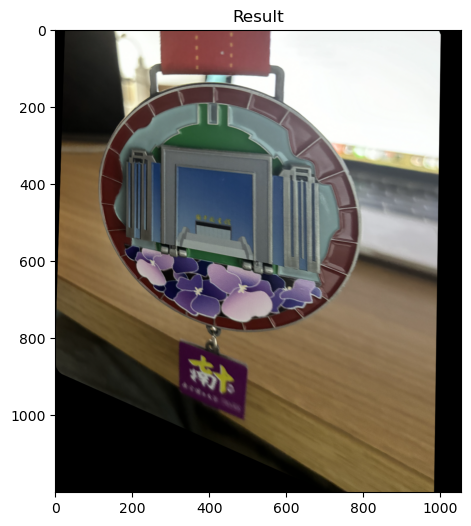

In [10]:
# 调用函数计算单应性变换矩阵并显示图像
image1 = cv2.imread('./image/picture1.png')
image2 = cv2.imread('./image/picture2.png')
compute_and_display_homography(image1, image2)